# Initial imports

In [3]:
pd.__version__

'0.25.0'

In [926]:
# Numeric and data processing
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from pandas.api.types import CategoricalDtype

# sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.metrics import cohen_kappa_score, f1_score, classification_report, matthews_corrcoef, make_scorer
from scipy.stats import ks_2samp
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, chi2, SelectKBest

# Hyperopt
from hyperopt import fmin, hp, tpe, rand, Trials, space_eval, STATUS_OK, anneal
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from functools import partial

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import scikitplot as skplt
import seaborn as sns

# lightgbm
import lightgbm as lgb

# Misc
import tqdm
import time
import gc


In [4]:
# Global random state for reproducibility
random_state_global = 42

# Dataprep

## Reading data from csv

8. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

In [5]:
df_full = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';', na_values=['unknown'])
df_full.columns = df_full.columns.str.replace('.', '_')

In [6]:
df_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
# Is there missing values on data? YES, I forced it using a_values=['unknown'] 
df_full.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
dtype: int64

## Categorical and numeric data preprocessing

## Categorical data

Some categorical have a meaningful ordering, like education ('basic.4y' < 'basic.6y',  ...) and default ('yes' > 'no'). For these
we will use this information while creating the category data type; for the others, there is no meaningful order, and we will not specify order while creating the category data type.

In [8]:
# Frequency of categories for each categorical feature
for col in df_full.select_dtypes('O').columns:
    print('\n', col)
    print(df_full[col].value_counts(dropna=False))


 job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: job, dtype: int64

 marital
married     24928
single      11568
divorced     4612
NaN            80
Name: marital, dtype: int64

 education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: education, dtype: int64

 default
no     32588
NaN     8597
yes        3
Name: default, dtype: int64

 housing
yes    21576
no     18622
NaN      990
Name: housing, dtype: int64

 loan
no     33950
yes     6248
NaN      990
Name: loan, dtype: int64

 contact
cellular     26144
telephone    15044
Name: contact, dtype: int64

 month
m

## Downcasting numeric features to reduce memory usage
(inspired on https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)

In [9]:
# Dict storing datatypes of all features
dict_dtypes = {}

# Categorical features with meaningful ordering
dict_dtypes['education'] = CategoricalDtype(categories = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                                                          'professional.course', 'university.degree']
                                            , ordered=True)

dict_dtypes['default'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['housing'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['loan'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['poutcome'] = CategoricalDtype(categories = ['failure', 'success'], ordered=True)# nonexistent considered as missing value
dict_dtypes['y'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)

# Polemic
dict_dtypes['day_of_week'] = CategoricalDtype(categories = ['mon', 'tue', 'wed', 'thu', 'fri'], ordered=True)
dict_dtypes['month'] = CategoricalDtype(categories = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                                     'sep', 'oct', 'nov', 'dec'], ordered=True)
# Other categorical features
for col in df_full.select_dtypes('O').columns:
    if col not in dict_dtypes.keys():
        dict_dtypes[col] = CategoricalDtype(categories = sorted(df_full[col].dropna().unique()), ordered=False)

In [10]:
# Note: pandas alerady have nullable integer datatypes, but I will not use. If a integer column have at least a missing value,
# it will be converted to float32.
for col in tqdm.tqdm(df_full.select_dtypes(np.number).columns, position=0, desc='Reducing memory usage for numeric columns'):
    _vec_min_max = df_full[col].describe()[['min','max']]
    _has_null = df_full[col].isnull().max()
    _has_float = (df_full[col] % 1 != 0).any()
    
    if _has_float or _has_null:
        dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='float').dtype
    else:
        if _vec_min_max[0] >=0:
            dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='unsigned').dtype
        else:
            dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='signed').dtype

start_memory_usage = df_full.memory_usage().sum() / 1024**2
end_memory_usage = df_full.astype(dict_dtypes).memory_usage().sum() / 1024**2

print('Initial memory usage: {:.2f} MB'.format(start_memory_usage))
print('Memory usage after optimization: {:.2f} MB'.format(end_memory_usage))
print('Memory usage decreased by {:.1f}%'.format(100 * (start_memory_usage - end_memory_usage) / start_memory_usage))

Reducing memory usage for numeric columns: 100%|███████████████████████████████████████| 10/10 [00:00<00:00, 60.94it/s]


Initial memory usage: 6.60 MB
Memory usage after optimization: 1.49 MB
Memory usage decreased by 77.3%


## Applying new dtypes inplace on initial dataframe

In [11]:
df_full = df_full.astype(dict_dtypes)

## Train test split

In [1079]:
# I used pd.get_dummies before splitting instead of including then on pipeline for simplicity
X_train_val, X_test, y_train_val, y_test = train_test_split(df_full.drop('y', axis=1), df_full['y'].cat.codes,
                                                    test_size=0.20, random_state=random_state_global)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                    test_size=0.20, random_state=random_state_global)

In [13]:
num_cols = df_full.select_dtypes(np.number).columns.to_list()
cat_cols = df_full.drop(['y'], axis=1).select_dtypes('category').columns.to_list()

## KS and gini functions and sklearn scorers

In [18]:
def ks_stat(y_true, y_proba):
#     As seen on https://medium.com/@xiaowei_6531/using-ks-stat-as-a-model-evaluation-metric-in-scikit-learns-gridsearchcv-33135101601c
    return ks_2samp(y_proba[y_true==1], y_proba[y_true!=1]).statistic

ks_scorer = make_scorer(ks_stat, needs_proba=True, greater_is_better=True)

#Remove redundant calls
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

gini_scorer = make_scorer(gini_normalizedc, needs_proba=True, greater_is_better=True)

## Training LGBM

Obs.: tentar maximizar número máximo de iterações antes de atingir early stopping faz com que tenhamos árvoes com depth baixo

## LGBM dart

[100]	train's auc: 0.933233	valid's auc: 0.930523
[200]	train's auc: 0.935195	valid's auc: 0.932748
[300]	train's auc: 0.935643	valid's auc: 0.932958
[400]	train's auc: 0.935173	valid's auc: 0.932131
[500]	train's auc: 0.936978	valid's auc: 0.933838
[600]	train's auc: 0.938514	valid's auc: 0.935192
[700]	train's auc: 0.938891	valid's auc: 0.935332
[800]	train's auc: 0.94229	valid's auc: 0.938401
[900]	train's auc: 0.944518	valid's auc: 0.940638
[1000]	train's auc: 0.946023	valid's auc: 0.942161
[1100]	train's auc: 0.947235	valid's auc: 0.943374
[1200]	train's auc: 0.947958	valid's auc: 0.943936
[1300]	train's auc: 0.94893	valid's auc: 0.944601
[1400]	train's auc: 0.949783	valid's auc: 0.94529
[1500]	train's auc: 0.950736	valid's auc: 0.946057
[1600]	train's auc: 0.951263	valid's auc: 0.946404
[1700]	train's auc: 0.95193	valid's auc: 0.94685
[1800]	train's auc: 0.952333	valid's auc: 0.947069
[1900]	train's auc: 0.952748	valid's auc: 0.947249
[2000]	train's auc: 0.953277	valid's auc: 0.9

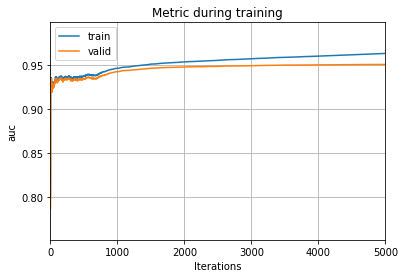

In [296]:
params_clf = {    
    'boost_from_average ': True,
    'boosting_type': 'dart',
    'class_weight': None,
    'colsample_bytree': 0.5,
    'importance_type': 'split',
    'learning_rate': 0.01,
    'max_depth': 10,
    'metric': 'auc',
    'min_child_samples': 500,
    'min_child_weight': 0,
    'min_split_gain': 0.0,
    'n_estimators': 5000,
    'n_jobs': -1,
    'num_leaves': 128,
    'objective': 'binary',
    'random_state': 42,
    'reg_alpha': 0,
    'reg_lambda': 0,
    'scale_pos_weight': 10,
    'silent': False,
    'subsample': 0.8,
    'subsample_for_bin': 20000,
    'subsample_freq': 1,
    'drop_rate': 0.5,
    'max_drop': -1
    
}

clf = lgb.LGBMClassifier(**params_clf)
clf.fit(X=X_train, y=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_names=['train', 'valid'], 
       eval_metric='auc', feature_name='auto',categorical_feature='auto', early_stopping_rounds=20, verbose=100)

lgb.plot_metric(clf)

## LGBM gradient boosting 

Training until validation scores don't improve for 50 rounds.
[500]	train's auc: 0.939822	valid's auc: 0.935862
[1000]	train's auc: 0.942248	valid's auc: 0.939357
[1500]	train's auc: 0.944592	valid's auc: 0.941934
[2000]	train's auc: 0.946231	valid's auc: 0.943523
[2500]	train's auc: 0.947563	valid's auc: 0.944633
[3000]	train's auc: 0.948681	valid's auc: 0.945467
[3500]	train's auc: 0.949687	valid's auc: 0.946155
[4000]	train's auc: 0.950542	valid's auc: 0.946659
[4500]	train's auc: 0.951309	valid's auc: 0.947142
[5000]	train's auc: 0.952012	valid's auc: 0.947472
[5500]	train's auc: 0.952648	valid's auc: 0.947758
[6000]	train's auc: 0.953246	valid's auc: 0.947984
[6500]	train's auc: 0.953833	valid's auc: 0.948177
[7000]	train's auc: 0.954371	valid's auc: 0.948393
[7500]	train's auc: 0.954889	valid's auc: 0.948549
[8000]	train's auc: 0.955375	valid's auc: 0.948717
Early stopping, best iteration is:
[8365]	train's auc: 0.955709	valid's auc: 0.948815


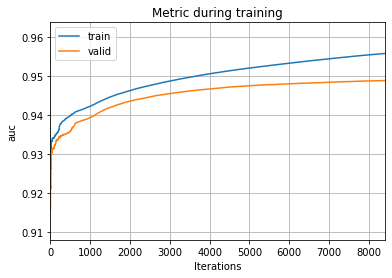

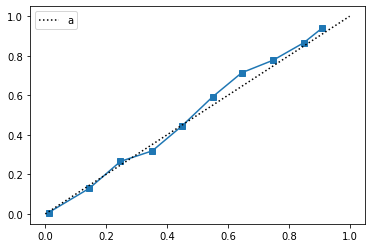

In [377]:
params_clf_2 = {    
    'boost_from_average ': True,
    'boosting_type': 'goss',
    'class_weight': None,
    'colsample_bytree': 0.8,
    'importance_type': 'split',
    'learning_rate': 0.002,
    'max_depth': -1,
    'metric': 'auc',
    'min_child_samples': 500,
    'min_child_weight': 0,
    'min_split_gain': 0.0,
    'n_estimators': 10000,
    'n_jobs': -1,
    'num_leaves': 100,
    'objective': 'binary',
    'random_state': 42,
    'reg_alpha': 10,
    'reg_lambda': 10,
    'scale_pos_weight': 1,
    'silent': False,
    'subsample': 1,
    'subsample_for_bin': 20000,
    'subsample_freq': 1,
}


clf_2 = lgb.LGBMClassifier(**params_clf_2)
clf_2.fit(X=X_train, y=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_names=['train', 'valid'], 
       eval_metric='auc', feature_name='auto',categorical_feature='auto', early_stopping_rounds=50, verbose=500)


lgb.plot_metric(clf_2)
plt.show()

fraction_of_positives, mean_predicted_value = \
    calibration_curve(y_train, clf_2.predict_proba(X_train)[:,1], n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, "s-")
plt.plot([0, 1], [0, 1], 'k:', label='a')
plt.title('Classifier calibration')
plt.legend()

## Score binning

In [376]:
print('train auc', roc_auc_score(y_train, clf_2.predict_proba(X_train)[:,1]))
print('val auc', roc_auc_score(y_val, clf_2.predict_proba(X_val)[:,1]))
print('test auc', roc_auc_score(y_test, clf_2.predict_proba(X_test)[:,1]))

train auc 0.9554036764436585
val auc 0.949368388206533
test auc 0.9483946601682263


In [382]:
_, bin_edges = pd.qcut(x=clf_2.predict_proba(X_test)[:,1], q=10, retbins=True)

In [396]:
bin_edges[1:-1]

array([0.00109723, 0.0014971 , 0.00212285, 0.0031961 , 0.00581919,
       0.01339757, 0.04910307, 0.20323622, 0.47728789])

In [404]:
bin_edges

array([5.05417450e-04, 1.09722543e-03, 1.49710401e-03, 2.12285120e-03,
       3.19610162e-03, 5.81919499e-03, 1.33975660e-02, 4.91030716e-02,
       2.03236218e-01, 4.77287887e-01, 9.24068104e-01])

In [591]:
bins.astype('int8')

array([3, 6, 6, ..., 3, 0, 7], dtype=int8)

In [594]:
bins, bin_edges = pd.qcut(x=clf_2.predict_proba(X_test)[:,1], q=10, retbins=True, labels=list(reversed(range(10))))
tmp_df = pd.DataFrame({'score': clf_2.predict_proba(X_test)[:,1],'target': y_test,'bin':bins.astype('int8')}, index=y_test.index)

# for predictions on new data, use np.concatenate([np.array([-np.inf]), bin_edges[1:-1], np.array([np.inf])])

df_group = tmp_df.groupby(['bin'])['score', 'target'].agg({'score':['min', 'max', 'mean'], 'target':['sum', 'mean', 'size']})\
.reset_index().sort_values(by='bin', ascending=True)
df_group.columns = ['bin','min_score', 'max_score', 'mean_score', 'sum_target_pos', 'mean_target', 'count']

# KS and accumulated response
df_group['sum_target_pos_pct_acc'] = df_group['sum_target_pos'].agg(lambda x: x.cumsum() / x.sum())
df_group['sum_target_neg_pct_acc'] = (df_group['count'] - df_group['sum_target_pos']).agg(lambda x: x.cumsum() / x.sum())
df_group['ks'] = df_group['sum_target_pos_pct_acc'] - df_group['sum_target_neg_pct_acc']
df_group['ks_max'] = df_group['ks'].max()

# lift
df_group['lift_pos'] = df_group['mean_score'] / (df_group['sum_target_pos'].sum() / df_group['count'].sum())
df_group['lift_neg'] = (1 - df_group['mean_score']) / (1 - (df_group['sum_target_pos'].sum() / df_group['count'].sum()))

# Cumulative gains



# df_group['delta_acc_target'] = df_group['sum_target_neg_acc'] - 
df_group

,bin,min_score,max_score,mean_score,sum_target_pos,mean_target,count,sum_target_pos_pct_acc,sum_target_neg_pct_acc,ks,ks_max,lift_pos,lift_neg
0,0,0.477399,0.924068,0.635933,542.0,0.657767,824,0.579679,0.038614,0.541065,0.763627,5.603014,0.410678
1,1,0.203256,0.477240,0.342361,278.0,0.337379,824,0.877005,0.113378,0.763627,0.763627,3.016434,0.741837
2,2,0.049104,0.203206,0.109326,84.0,0.101942,824,0.966845,0.214706,0.752139,0.763627,0.963238,1.004707
3,3,0.013439,0.049097,0.026275,26.0,0.031592,823,0.994652,0.323840,0.670813,0.763627,0.231500,1.098391
4,4,0.005821,0.013387,0.008805,3.0,0.003641,824,0.997861,0.436259,0.561602,0.763627,0.077576,1.118098
5,5,0.003197,0.005818,0.004281,1.0,0.001214,824,0.998930,0.548952,0.449978,0.763627,0.037718,1.123201
6,6,0.002123,0.003194,0.002612,1.0,0.001215,823,1.000000,0.661509,0.338491,0.763627,0.023010,1.125084
7,7,0.001497,0.002123,0.001791,0.0,0.000000,824,1.000000,0.774339,0.225661,0.763627,0.015784,1.126009
8,8,0.001097,0.001497,0.001288,0.0,0.000000,824,1.000000,0.887170,0.112830,0.763627,0.011346,1.126577
9,9,0.000505,0.001097,0.000888,0.0,0.000000,824,1.000000,1.000000,0.000000,0.763627,0.007824,1.127028


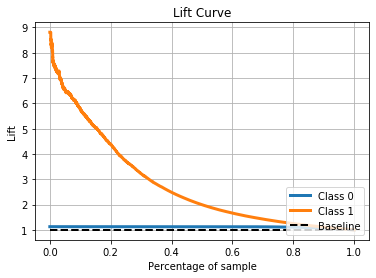

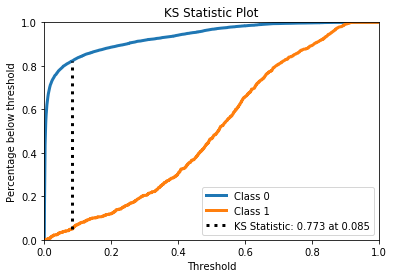

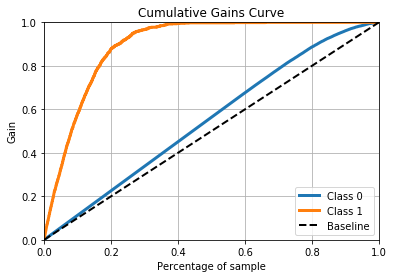

In [619]:
skplt.metrics.plot_lift_curve(y_test, clf_2.predict_proba(X_test))
skplt.metrics.plot_ks_statistic(y_test, clf_2.predict_proba(X_test))
skplt.metrics.plot_cumulative_gain(y_test, clf_2.predict_proba(X_test))

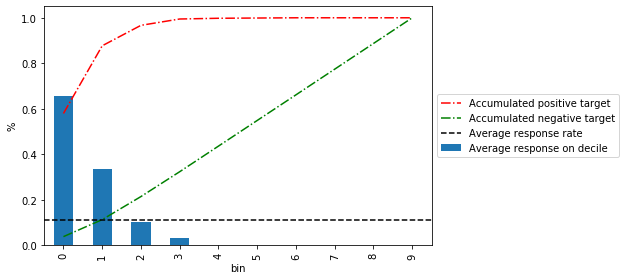

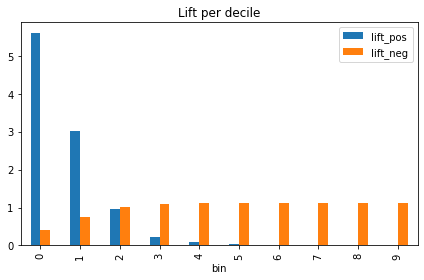

In [714]:
df_group.plot(x='bin', y=['mean_target'], kind='bar', label=['Average response on decile'])
plt.plot(df_group['bin'], df_group['sum_target_pos_pct_acc'], '-.r', label='Accumulated positive target')
plt.plot(df_group['bin'], df_group['sum_target_neg_pct_acc'], '-.g', label='Accumulated negative target')
plt.axhline(y_test.mean(),  color='k', linestyle='--', label='Average response rate')
plt.tight_layout()
plt.ylabel('%')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

df_group.plot(x='bin', y=['lift_pos', 'lift_neg'], kind='bar')
plt.title('Lift per decile')
plt.tight_layout()

In [720]:
bins, bin_edges = pd.qcut(x=clf_2.predict_proba(X_test)[:,1], q=10, retbins=True, labels=list(reversed(range(10))))
tmp_df = pd.DataFrame({'score': clf_2.predict_proba(X_test)[:,1],'target': y_test,'bin':bins.astype('int8')}, index=y_test.index)

# for predictions on new data, use np.concatenate([np.array([-np.inf]), bin_edges[1:-1], np.array([np.inf])])

df_group = tmp_df.groupby(['bin'])['score', 'target'].agg({'score':['min', 'max', 'mean'], 'target':['sum', 'mean', 'size']})\
.reset_index().sort_values(by='bin', ascending=True)
df_group.columns = ['bin','min_score', 'max_score', 'mean_score', 'sum_target_pos', 'mean_target', 'count']

# KS and accumulated response
df_group['sum_target_pos_pct_acc'] = df_group['sum_target_pos'].agg(lambda x: x.cumsum() / x.sum())
df_group['sum_target_neg_pct_acc'] = (df_group['count'] - df_group['sum_target_pos']).agg(lambda x: x.cumsum() / x.sum())
df_group['ks'] = df_group['sum_target_pos_pct_acc'] - df_group['sum_target_neg_pct_acc']
df_group['ks_max'] = df_group['ks'].max()

# lift
df_group['lift_pos'] = df_group['mean_score'] / (df_group['sum_target_pos'].sum() / df_group['count'].sum())
df_group['lift_neg'] = (1 - df_group['mean_score']) / (1 - (df_group['sum_target_pos'].sum() / df_group['count'].sum()))

# Cumulative gains

# df_group['delta_acc_target'] = df_group['sum_target_neg_acc'] - 
df_group

,bin,min_score,max_score,mean_score,sum_target_pos,mean_target,count,sum_target_pos_pct_acc,sum_target_neg_pct_acc,ks,ks_max,lift_pos,lift_neg
0,0,0.477399,0.924068,0.635933,542.0,0.657767,824,0.579679,0.038614,0.541065,0.763627,5.603014,0.410678
1,1,0.203256,0.477240,0.342361,278.0,0.337379,824,0.877005,0.113378,0.763627,0.763627,3.016434,0.741837
2,2,0.049104,0.203206,0.109326,84.0,0.101942,824,0.966845,0.214706,0.752139,0.763627,0.963238,1.004707
3,3,0.013439,0.049097,0.026275,26.0,0.031592,823,0.994652,0.323840,0.670813,0.763627,0.231500,1.098391
4,4,0.005821,0.013387,0.008805,3.0,0.003641,824,0.997861,0.436259,0.561602,0.763627,0.077576,1.118098
5,5,0.003197,0.005818,0.004281,1.0,0.001214,824,0.998930,0.548952,0.449978,0.763627,0.037718,1.123201
6,6,0.002123,0.003194,0.002612,1.0,0.001215,823,1.000000,0.661509,0.338491,0.763627,0.023010,1.125084
7,7,0.001497,0.002123,0.001791,0.0,0.000000,824,1.000000,0.774339,0.225661,0.763627,0.015784,1.126009
8,8,0.001097,0.001497,0.001288,0.0,0.000000,824,1.000000,0.887170,0.112830,0.763627,0.011346,1.126577
9,9,0.000505,0.001097,0.000888,0.0,0.000000,824,1.000000,1.000000,0.000000,0.763627,0.007824,1.127028


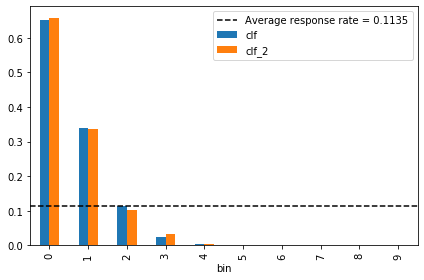

In [943]:
def compare_models_bins(y_true, y_probas_dict, n_bins=10):
    _tmp_df = pd.DataFrame({**{'y_true':y_true}, **y_probas_dict})
    _tmp_df_group = pd.DataFrame({'bin':range(n_bins)})
    for key in y_probas_dict.keys():
        _tmp_df['bins_' + key] = pd.qcut(x=y_probas_dict[key], q=n_bins, retbins=False,
                                  labels=list(reversed(range(n_bins)))).astype('int8')
        
        _tmp_df_group = _tmp_df_group.merge(_tmp_df.groupby('bins_' + key)['y_true'].mean().reset_index()\
                                            .rename(columns={'y_true':key}),
                                            how='left',left_on='bin', right_on='bins_' + key).drop('bins_' + key, axis=1)
        
#     return _tmp_df, _tmp_df_group
    _tmp_df_group.plot(x='bin', kind='bar')
    plt.axhline(y_true.mean(),  color='k', linestyle='--', label=f'Average response rate = {round(y_true.mean(), 4)}')
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_models_bins(y_true=y_test, y_probas_dict={'clf':clf.predict_proba(X_test)[:,1],
                                                  'clf_2':clf_2.predict_proba(X_test)[:,1]}, n_bins=10)

## Feature descriptive statistics

In [1080]:
X_test_ = X_test.copy()
X_test_['bin'] = bins.astype('int8')
X_test_['score'] = clf_2.predict_proba(X_test)[:,1]
X_test_['target'] = y_test.values

duration


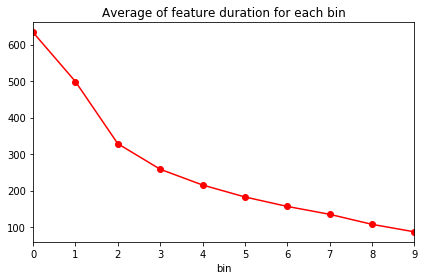

euribor3m


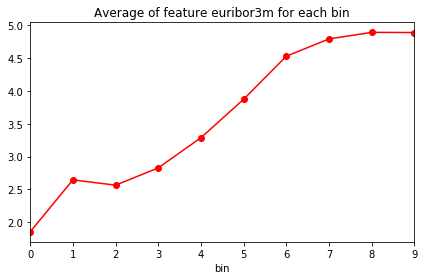

month


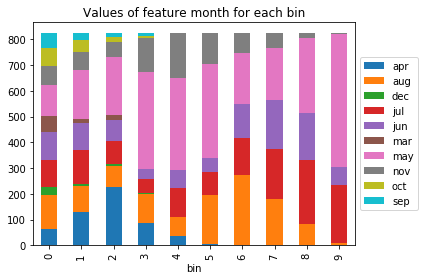

job


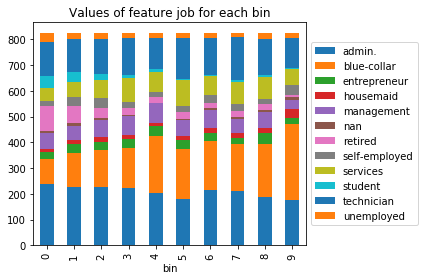

age


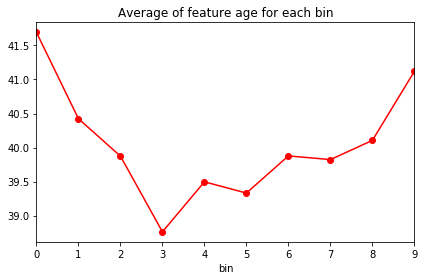

education


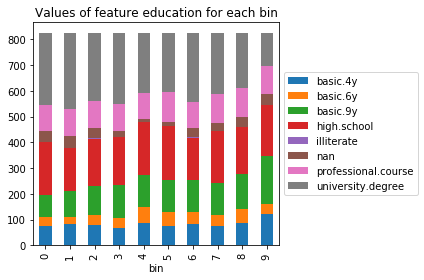

day_of_week


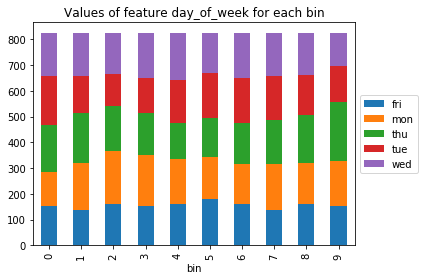

cons_conf_idx


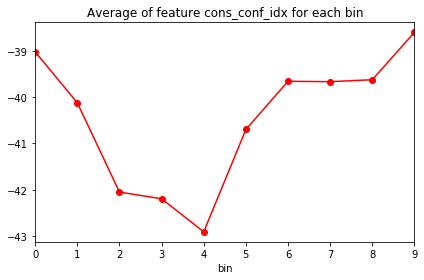

emp_var_rate


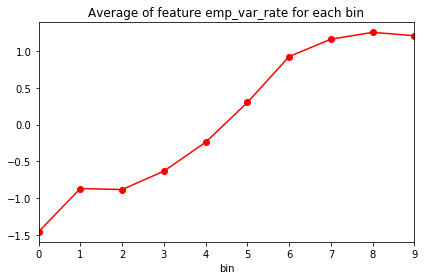

cons_price_idx


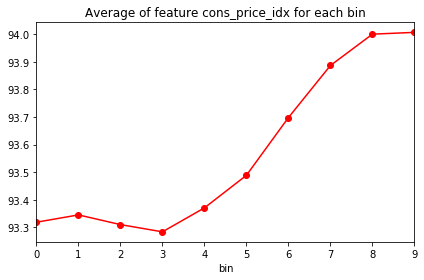

campaign


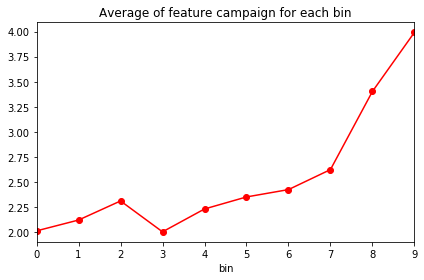

nr_employed


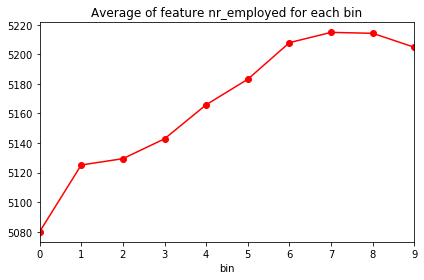

pdays


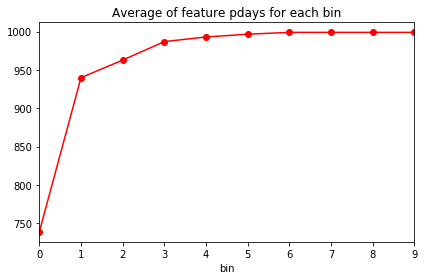

contact


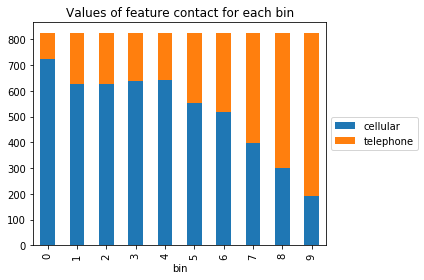

poutcome


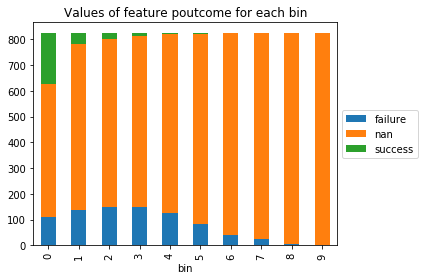

housing


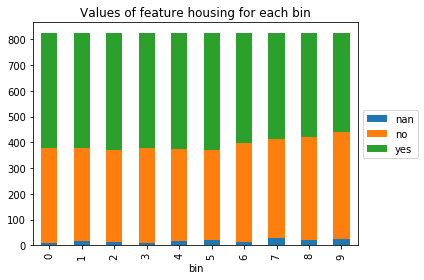

marital


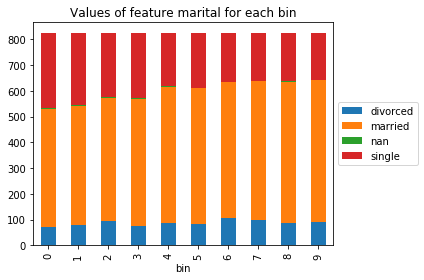

default


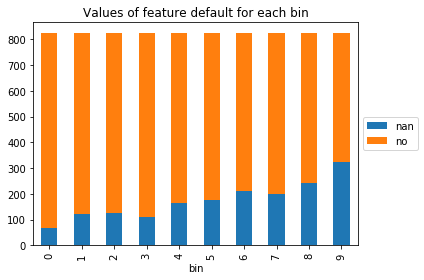

previous


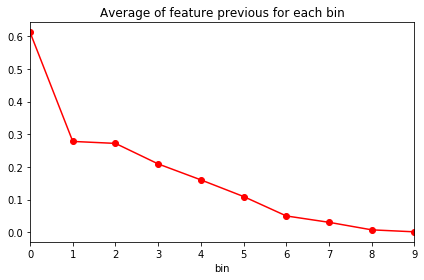

loan


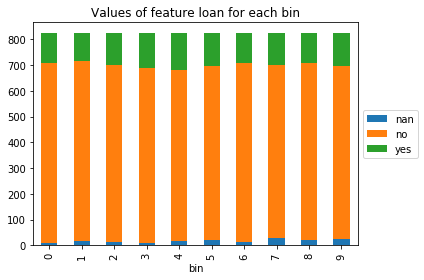

In [1081]:
for col in np.array(clf_2.booster_.feature_name())[np.argsort(-clf_2.booster_.feature_importance())]:
    if pd.api.types.is_categorical(X_test_[col]):
        print(col)
        X_test_.astype(str).groupby(['bin', col]).size().unstack().plot(kind='bar', stacked=True)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f'Values of feature {col} for each bin')
        plt.tight_layout()
        plt.show()
        
    elif pd.api.types.is_numeric_dtype(X_test_[col]):
        print(col)
        X_test_.groupby('bin')[col].mean().plot(style='-ro')
        plt.title(f'Average of feature {col} for each bin')
        plt.tight_layout()
        plt.show()
    else:
        print(f'Error (col {col}) must be of numeric or categorical dtypes')
        

In [1083]:
X_test_.groupby('bin').mean().reset_index().T

,0,1,2,3,4,5,6,7,8,9
bin,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000
age,41.691748,40.423544,39.873786,38.761847,39.496359,39.331311,39.877278,39.822816,40.105583,41.120146
duration,633.750000,498.906553,328.546117,258.609964,215.390777,182.638350,156.663426,135.091019,107.594660,87.077670
campaign,2.010922,2.118932,2.309466,2.001215,2.229369,2.349515,2.422843,2.622573,3.402913,3.992718
pdays,738.743932,939.919903,962.848301,986.941677,992.987864,996.594660,999.000000,999.000000,999.000000,999.000000
previous,0.611650,0.277913,0.271845,0.208991,0.160194,0.109223,0.049818,0.030340,0.007282,0.001214
emp_var_rate,-1.456432,-0.867961,-0.882039,-0.632321,-0.239684,0.300850,0.925273,1.161044,1.253398,1.208131
cons_price_idx,93.318993,93.345459,93.310364,93.284172,93.370903,93.488876,93.697830,93.886536,93.999992,94.006477
cons_conf_idx,-39.024273,-40.124516,-42.048302,-42.192711,-42.905949,-40.697937,-39.658203,-39.667233,-39.625244,-38.603886
euribor3m,1.850017,2.643231,2.562340,2.826103,3.287276,3.873811,4.531269,4.794865,4.895027,4.892857
